In [ ]:
import os.path as path
import raw_data_preprocessing as rdp
import warnings
import regressor as reg
import cluster as clu
import intervention_data_preprocessing as idp
import individual_differences_plot as plot
warnings.filterwarnings('ignore')

googledrive_loc = '/datasets/googledrive'
data_folder_loc = 'Yi_UCI_research/GSR other works/2020 Summer_predict individual training/data/'
file_name = 'raw data/yi feng larger dataset_new.csv'
data_path = path.join(googledrive_loc, data_folder_loc, file_name)
raw_data = rdp.read_raw_data(data_path)
print('Used Feature columns: {}'.format(rdp.feature_col_names))
data_no_missing = rdp.delete_missing_row(raw_data)
rdp.demographic_info(data_no_missing)
rdp.descriptive_info(data_no_missing)

Used Feature columns: ['z_Updating_pre', 'z_WM_pre', 'z_IC_pre', 'MRpre', 'TCA', 'CFQ', 'z_Grit_Ambition', 'Person_emot', 'Person_extraver', 'Person_opennes', 'Person_agreeable', 'Person_conscien', 'VGQ_pastyear', 'z_SES']
The sample size of raw data is 392.
The sample size of no missing data is 363.
Demographoc information:Study
1    180
2     60
3    123
dtype: int64
Demographoc information:Gender
Female                            238
Male                              122
Other or Don't Want to Specify      3
dtype: int64
Demographoc information:Ethnicity
American Indian/Alaska Native                                                2
American Indian/Alaska Native,Native Hawaiian or Other Pacific Islander      1
American Indian/Alaska Native,White                                          1
Asian                                                                      176
Asian,Black or African American                                              3
Asian,Black or African American,Other or 

In [ ]:
int_test = idp.InterventionProcessor(data_no_missing)
int_test.basic_analyze()
int_test.mark_outlier_stewd(['std'])
int_test.delete_outlier()
piece_lin_reg = reg.PiecewiselinRegressor(['knot', 'slope1', 'slope2','turning_value'])
log_lin_reg = reg.LogRegressor(['log_slope', 'log_bias'])
lin_reg = reg.LinearRegressor(['linear_slope', 'linear_bias'])
int_test.register_regressor(piece_lin_reg)
int_test.fit()
int_test.mark_outlier_stewd(['slope1'])
int_test.delete_outlier()
# plot.plot_distribution(int_test.data, ['knot','slope1','slope2','std','max','r2'])

The mean of max is 5.318 with sd 5.885
The mean of std is 0.923 with sd 1.785
The skew of std is 7.387
std:MC=0.192
interval of std is 2.7972694256620017 to -0.15328719937519236
          ID   WmeanN_1   WmeanN_2   WmeanN_3   WmeanN_4   WmeanN_5  \
68   IGTA108   4.618750  11.595745  12.223529   8.983359  11.188148   
111  RRTA111   4.643478   5.691265   6.327869   6.293395   7.587888   
171  RRTA112   3.288571   4.154074   4.498555   4.687055   9.390788   
200   RLB131   9.059113  10.766938   9.817927  10.956873  13.827957   
229   ILB205   3.147945   3.640827   4.560302   8.041775   9.454774   
230   ILB208  14.159151  35.433875  49.548303  60.698113  69.022388   
231   ILB209  11.587342  23.429688  26.316076  33.257703  42.155080   
260   RLB140   2.000000   4.082153   4.939655  15.221024  23.300771   
289  iSOL178   2.500000   2.990000   3.570000   4.080000   5.680000   
304   LOL125   4.110000   6.450000   9.120000   7.910000   9.370000   
344  RSOL133   2.600000   2.520000   2.81

The silhouette score of GaussianMixture(n_components=3, random_state=0) is: 0.366
Sample of each cluster: label
0     93
1    144
2    105
dtype: int64
The mean of each mixture component: [[-1.1757202   1.11796428]
 [ 0.97429368 -0.68638638]
 [-0.32600883  0.01536337]]


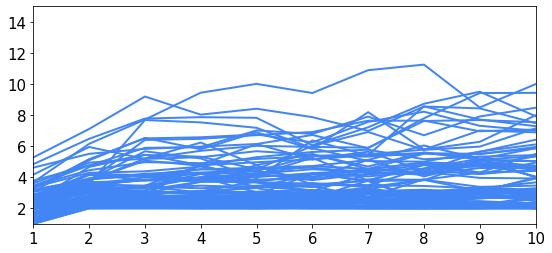

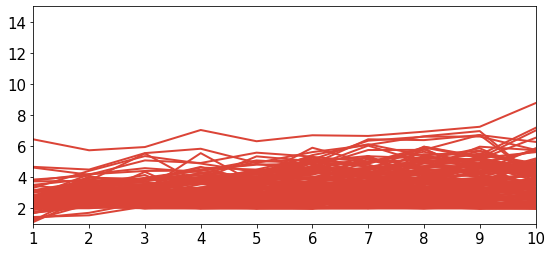

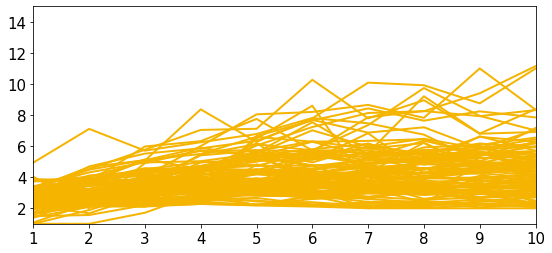

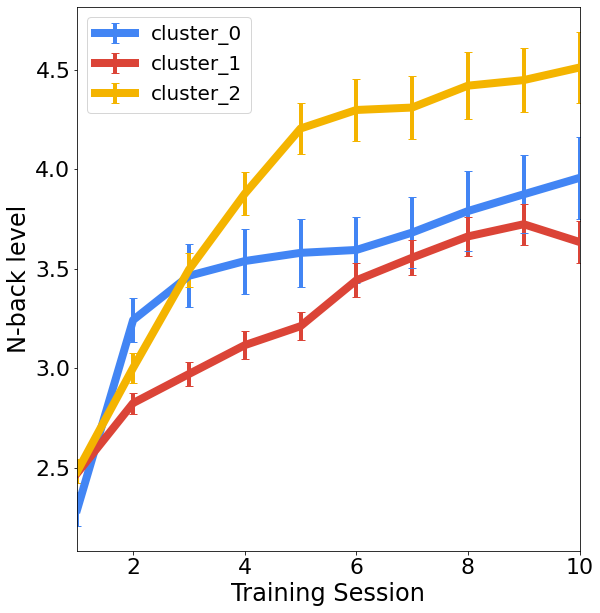

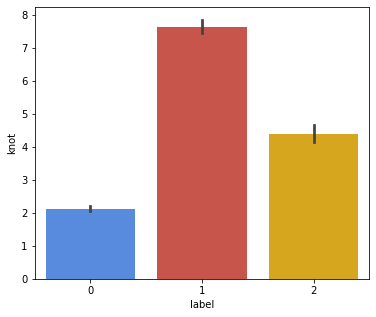

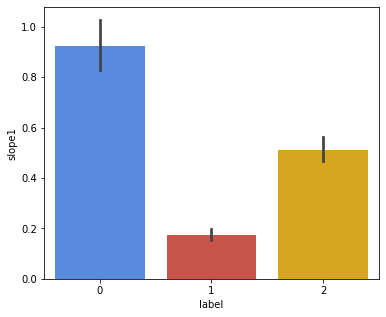

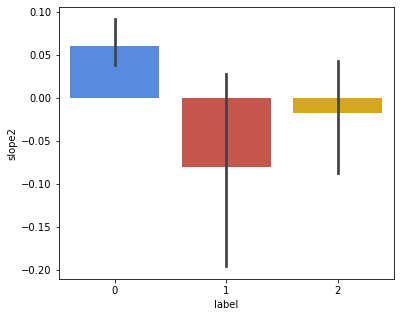

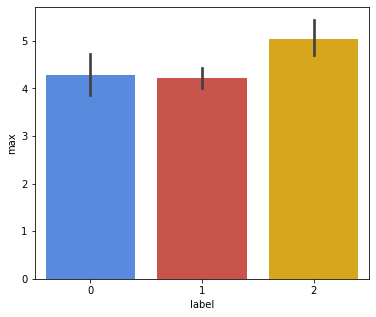

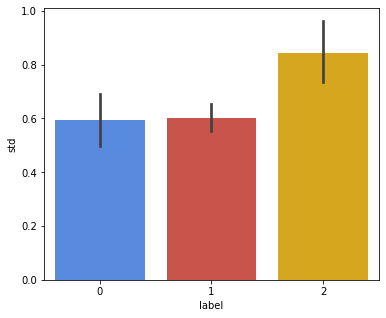

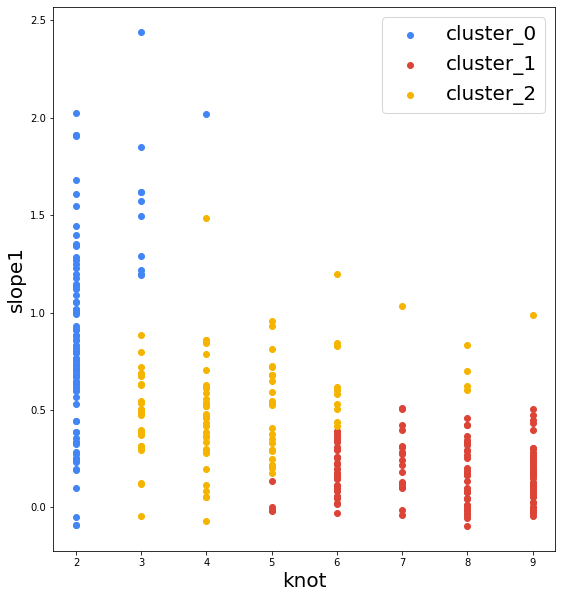

In [ ]:
# clustering
kmeans_3com = clu.Kmeans(3, ['knot', 'slope1'])
em_3com = clu.EM(3, ['knot','slope1'])
int_test.register_cluster_model(em_3com)
int_test.cluster()
# plot
plot.plot_cluster_result(int_test.data, int_test.intervention_col_names, 'label')
plot.bar_plot_cluster(int_test.data, ['knot','slope1','slope2', 'max','std'])
plot.plot_scatter_cluster(int_test.data, ['knot','slope1'])

In [ ]:
import feature_preprocessor as fp
fp_test = fp.FeatureProcessor(data_no_missing)
# fp_test.corr_features()
# fp_test.distri_features()
fp_test.discretize_features()

In [ ]:
import classification_preprocessor as cp
cp_test = cp.ClassifyPreprocessor(int_test.data, fp_test.data)
# cp_test.delete_outlier() 
# cp_test.feature_test()
cp_test.feature_selection(14)
# cp_test.use_categorical_features()

z_WM_pre 3.5257499362525206
MRpre 2.0229236497015384
z_Grit_Ambition 1.9984130952382948
Person_opennes 1.8220025975064114
z_IC_pre 1.6842278278652971
z_Updating_pre 0.8442692922838329
Person_extraver 0.8013893282781306
z_SES 0.7630881046579272
TCA 0.7372808918217114
VGQ_pastyear 0.5361447380967127
Person_conscien 0.4462231981597765
Person_emot 0.433071468102995
Person_agreeable 0.35654893553228434
CFQ 0.11779053905628864
The top 14 features are: ['z_WM_pre', 'MRpre', 'z_Grit_Ambition', 'Person_opennes', 'z_IC_pre', 'z_Updating_pre', 'Person_extraver', 'z_SES', 'TCA', 'VGQ_pastyear', 'Person_conscien', 'Person_emot', 'Person_agreeable', 'CFQ']


In [ ]:
X, Y, orig_len, feature_names = cp_test.resample_standardize({0:120, 1:144, 2:120})
print('The input and output shape: {} and {}'.format(X.shape, Y.shape))
# saved_data_path = path.join(googledrive_loc, data_folder_loc, 'saved data/test/')
# cp_test.save_data(X, Y, orig_len, feature_names, saved_data_path)

The sample weight before resample: Counter({1: 144, 2: 105, 0: 93})
The sample weight after resample: Counter({1: 144, 2: 120, 0: 120})
The input and output shape: (384, 14) and (384,)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b8ead81-70bf-4d6b-bd50-8194f8f72b46' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>